In [1]:
import warnings
import My_functions as fc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
%matplotlib inline
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 40)

# Датасет

В рамках одного из проектов UNICEF по повышению уровня благополучия детей по всему миру, собрана база данных учеников двух школ, где приведена оценка различных условий их жизни.

**Задача**

Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на величину балла полученного за госэкзамн по математике.

In [2]:
DATA_DIR = './'
math_data = pd.read_csv(DATA_DIR+'stud_math.csv')

In [3]:
display(math_data.sample(7))
math_data.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
132,GP,F,17,U,LE3,T,2.0,2.0,other,other,course,father,NaN,1.0,0.0,no,yes,no,no,yes,-3.0,yes,NaN,yes,3.0,4.0,4.0,5.0,12.0,60.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
274,GP,F,17,U,GT3,T,2.0,4.0,at_home,health,reputation,mother,2.0,2.0,0.0,NaN,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,3.0,3.0,1.0,2.0,50.0
369,MS,F,18,R,GT3,T,4.0,4.0,other,teacher,other,father,3.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,yes,3.0,2.0,2.0,5.0,10.0,55.0
387,MS,F,19,R,GT3,T,2.0,3.0,services,other,course,mother,1.0,3.0,1.0,no,no,no,yes,no,-9.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,0.0
179,GP,M,17,U,GT3,T,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,2.0,3.0,2.0,4.0,55.0
45,GP,F,15,U,LE3,A,4.0,3.0,other,other,course,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,yes,5.0,2.0,2.0,5.0,8.0,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

В датасете 395 наблюдений и 30 колонок(признаков) в т.ч. 13 числовых признаков (включая целевую переменную - "score") и 17 категориальных (номинативных признаков). 

### Первоначальное описание колонок:

1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0**: нет, **1**: 4 класса, **2**: 5-9 классов,
    **3**: среднее специальное или 11 классов, **4**: высшее);

8 **f_edu** — образование отца (**0**: нет, **1**: 4 класса, **2**: 5-9 классов, 
    **3**: среднее специальное или 11 классов, **4**: высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения,  
    **services'** - гос служба,  **'at_home'** - не работает,  **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1**: <15 мин., **2**: 15-30 мин., 
    **3**: 30-60 мин., **4**: >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1**: <2 часов, **2**: 2-5 часов, 
    **3**: 5-10 часов, **4**: >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<=3, иначе **0**); 

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health_level** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).

Судя по описанию датасета, к числовым отнесены номинативные признаки, зашифрованные в числовой шкале. Приведем их тип к номинативному.

In [4]:
for column in ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime, granular', 'famrel', 'freetime', 'goout', 'health']:
    fc.change_to_object(column, data=math_data)

Переименуем колонки, приведя их название к единообразномуму виду.

In [5]:
math_data.columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
                     'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time',
                     'failures', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
                     'study_time_granular', 'higher', 'internet', 'romantic', 'fam_rel',
                     'free_time', 'go_out', 'health', 'absences', 'score']

In [6]:
math_describe = math_data.describe(include=[object])
display(math_describe)

,school,sex,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,study_time_granular,higher,internet,romantic,fam_rel,free_time,go_out,health
count,395,395,378,368,350,392.0,371.0,376,359,378,364,367.0,388.0,373.0,386,356,355,381,379,388.0,375,361,364,368.0,384.0,387.0,380.0
unique,2,2,2,2,2,5.0,6.0,5,5,4,3,4.0,4.0,4.0,2,2,2,2,2,4.0,2,2,2,6.0,5.0,5.0,5.0
top,GP,F,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0
freq,349,208,295,261,314,131.0,106.0,133,197,137,250,242.0,194.0,293.0,335,219,200,195,300,194.0,356,305,240,182.0,153.0,127.0,138.0


Часть столбцов имеет по два уникальных значения. Поэтому номинативные колонки (categorical_columns) можно разделить на бинарные и небинарные.

Таким образом для анализа получаем три типа колонок:

- колонки с числовыми признаками (numerical_columns)
- колонки с номинативными бинарными признаками (binary_columns)
- колонки с номинативными небинарными признаками (nonbinary_columns)

In [7]:
numerical_columns = [
    c for c in math_data.columns if math_data[c].dtype.name != 'object']
categorical_columns = [
    c for c in math_data.columns if math_data[c].dtype.name == 'object']
binary_columns = [
    c for c in categorical_columns if math_describe[c]['unique'] == 2]
nonbinary_columns = [
    c for c in categorical_columns if math_describe[c]['unique'] > 2]

In [8]:
print(f'{len(numerical_columns)} колонки с числовыми признаками: {numerical_columns}')
print()
print(f'{len(binary_columns)} категориальных колонок с бинарными признаками: {binary_columns}')
print()
print(f'{len(nonbinary_columns)} категориальных колонок с небинарными признаками: {nonbinary_columns}')

3 колонки с числовыми признаками: ['age', 'absences', 'score']

13 категориальных колонок с бинарными признаками: ['school', 'sex', 'address', 'fam_size', 'p_status', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

14 категориальных колонок с небинарными признаками: ['m_edu', 'f_edu', 'm_job', 'f_job', 'reason', 'guardian', 'travel_time', 'study_time', 'failures', 'study_time_granular', 'fam_rel', 'free_time', 'go_out', 'health']


# Колонки с числовыми признаками

In [9]:
math_data.describe()

,age,absences,score
count,395.000000,383.000000,389.000000
mean,16.696203,7.279373,52.262211
std,1.276043,23.465197,22.919022
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,40.000000
50%,17.000000,4.000000,55.000000
75%,18.000000,8.000000,70.000000
max,22.000000,385.000000,100.000000


В датасете всего 3 колонки с числовыми признаками. Рассмотрим каждую.

## Колонка c целевой переменной "score"

In [10]:
fc.print_summary(column='score', data=math_data)

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Количество уникальных значений: 18
Количество пустых значений: 6


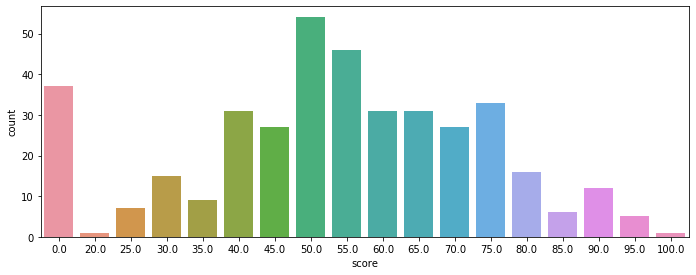

In [11]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 0.8])
sns.countplot(x='score', data=math_data)

Распределение почти нормальное. Самое большое количество студентов получили оценку от 50 до 55. Однако обращает на себя внимание то, что около 40 студентов получили оценку - 0 баллов. Скорее всего это те, кто либо не пришел на экзамен, либо не стал сдавать работу на проверку. Посколку это весьма многочисленная группа, относить ее к выбросам не стоит, но возможно стоит рассмотреть её отдельно.

In [12]:
math_data.loc[math_data['score'].isnull()]

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,study_time_granular,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
201,GP,F,16,U,GT3,T,2,3,other,other,reputation,mother,1,2,0,yes,yes,NaN,yes,yes,-6,yes,no,no,4,NaN,3,4,6.0,NaN
244,GP,F,18,U,GT3,T,2,1,other,other,course,other,2,3,0,no,yes,yes,no,no,-9,yes,yes,yes,4,4,4,3,0.0,NaN
270,GP,F,19,NaN,GT3,T,3,3,other,services,home,other,1,2,2,no,yes,yes,yes,yes,-6,yes,yes,no,4,3,5,5,NaN,NaN
283,GP,F,18,U,GT3,T,1,1,other,other,home,mother,2,2,0,yes,NaN,no,yes,yes,-6,yes,yes,no,5,NaN,4,4,4.0,NaN
312,GP,M,19,U,GT3,T,1,2,other,services,course,other,1,2,1,no,no,no,no,no,-6,yes,yes,no,4,5,NaN,4,3.0,NaN
350,MS,M,19,NaN,GT3,T,1,1,other,services,home,other,3,2,3,no,no,no,no,NaN,-6,yes,yes,no,5,4,4,2,8.0,NaN


В датасете всего шесть записей с пустым значением целевой переменной. Удалим их.

In [13]:
math_data.drop([0, 201, 244, 270, 283, 312, 350], inplace=True)

## Колонка "age"

In [14]:
fc.print_summary(column='age', data=math_data)

count    388.000000
mean      16.670103
std        1.265496
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Количество уникальных значений: 8
Количество пустых значений: 0


Text(0.5, 0, 'Возраст учеников')

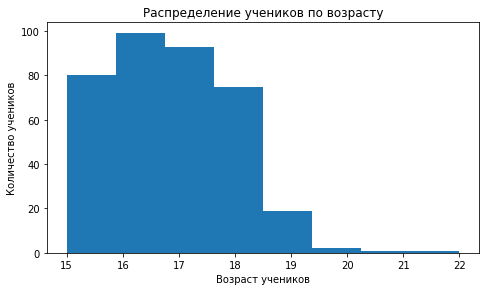

In [91]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 0.8])
axes.hist(math_data['age'], bins=8)
axes.set_title('Распределение учеников по возрасту')
axes.set_ylabel('Количество учеников')
axes.set_xlabel('Возраст учеников')

Распределение почти нормальное, пропусков нет, медианное и среднее значение возраста близки. Студентов в возрасте 21-22 нельзя считать выбросами, т.к. согласно описанию колонки это не ошибка.

## Колонка "ABSENCES"

In [16]:
fc.print_summary(data=math_data, column='absences')

count    377.000000
mean       7.323607
std       23.646809
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Количество уникальных значений: 36
Количество пустых значений: 11


Text(0.5, 0, 'Количество пропусков')

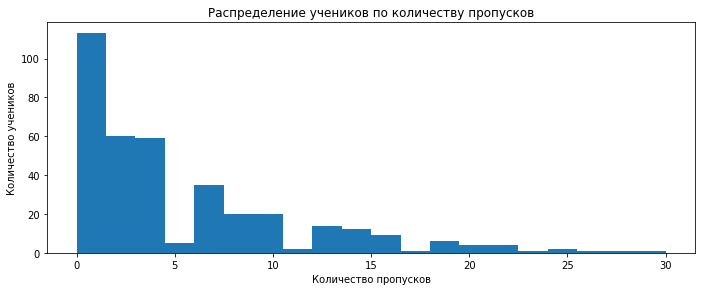

In [92]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 0.8])
axes.hist(math_data['absences'], bins=20)
axes.set_title('Распределение учеников по количеству пропусков')
axes.set_ylabel('Количество учеников')
axes.set_xlabel('Количество пропусков')

Как видно из гистограммы, большинство студентов либо вообще не пропускали, либо пропустили менее 50 занятий. Также присутствуют явные выбросы, которые повлияли на сильное отличее среднего количества пропусков от медианы и величину стандартного отклонения. К явным выбросам можно отнести те, что превышают количество учебных дней в году (более 200). Выполним проверку на неявные выбросы.

25%-й перцентиль: 0.0, 75%-й перцентиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0].

Количество записей с пропуском более 20.0 занятий : 17


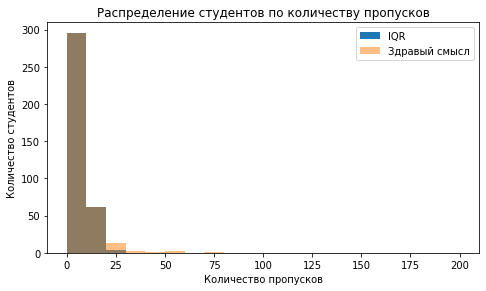

In [18]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 0.8])

axes.set_title('Распределение студентов по количеству пропусков')
axes.set_ylabel('Количество студентов')
axes.set_xlabel('Количество пропусков')
median = math_data.absences.median()
IQR = math_data.absences.quantile(0.75) - math_data.absences.quantile(0.25)
perc25 = math_data.absences.quantile(0.25)
perc75 = math_data.absences.quantile(0.75)
print(
    f"25%-й перцентиль: {perc25}, 75%-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}].")
axes.hist(math_data.absences.loc[math_data.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)], bins=20, range=(0, 200),
          label='IQR')
axes.hist(math_data['absences'], alpha=0.5, bins=20,
          range=(0, 200), label='Здравый смысл')
plt.legend()
print()
print(
    f'Количество записей с пропуском более {perc75 + 1.5*IQR} занятий : {len(math_data.loc[math_data.absences > perc75 + 1.5*IQR])}')

Поскольку верхняя граница получилась слишком жесткой и "лишними" становятся 17 записей, т.е. пропуск более 20 занятий не такой уж редкий случай, попробуем смягчить границы выбросов.

10%-й перцентиль: 0.0, 90%-й перцентиль: 14.0, IQR: 14.0, Границы выбросов: [-21.0, 35.0].

Количество записей с пропуском более 35.0 занятий : 0


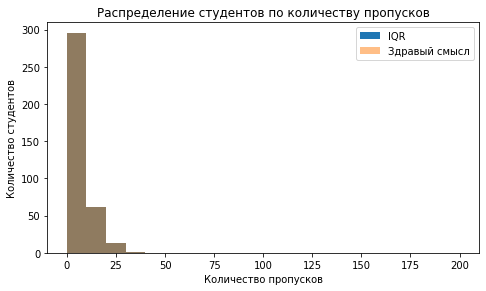

In [93]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 0.8])

axes.set_title('Распределение студентов по количеству пропусков')
axes.set_ylabel('Количество студентов')
axes.set_xlabel('Количество пропусков')
median = math_data.absences.median()
IQR = math_data.absences.quantile(0.9) - math_data.absences.quantile(0.1)
perc10 = math_data.absences.quantile(0.1)
perc90 = math_data.absences.quantile(0.9)
print(
    f"10%-й перцентиль: {perc10}, 90%-й перцентиль: {perc90}, IQR: {IQR}, Границы выбросов: [{perc10 - 1.5*IQR}, {perc90 + 1.5*IQR}].")
axes.hist(math_data.absences.loc[math_data.absences.between(perc10 - 1.5*IQR, perc90 + 1.5*IQR)], bins=20, range=(0, 200),
          label='IQR')
axes.hist(math_data['absences'], alpha=0.5, bins=20,
          range=(0, 200), label='Здравый смысл')
plt.legend()
print()
print(
    f'Количество записей с пропуском более {perc90 + 1.5*IQR} занятий : {len(math_data.loc[math_data.absences > perc90 + 1.5*IQR])}')

Удаляем из датасета все записи, где пропусков занятий больше 35.

In [20]:
math_data = math_data.loc[math_data.absences < 35]

Text(0.5, 0, 'Количество пропусков')

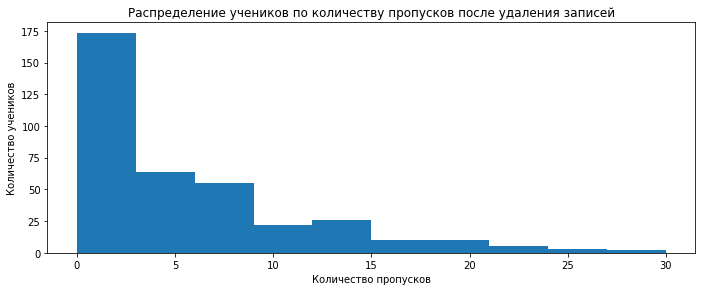

In [94]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 0.8])
axes.hist(math_data['absences'], bins=10)
axes.set_title(
    'Распределение учеников по количеству пропусков после удаления записей')
axes.set_ylabel('Количество учеников')
axes.set_xlabel('Количество пропусков')

## Корреляционный анализ

,age,absences,score
age,1.000000,0.155577,-0.145361
absences,0.155577,1.000000,0.069355
score,-0.145361,0.069355,1.000000


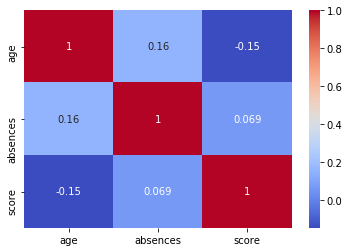

In [22]:
correlation = math_data.corr()
display(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Как видно из тепловой карты скоррелированных переменных нет (индекс корреляции по модулю не превышает 0.07). Т.о. для модели можно оставить все числовые признаки.

# Колонки с небинарными номинативными признаками

In [23]:
math_data[nonbinary_columns].describe()

,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,study_time_granular,fam_rel,free_time,go_out,health
count,367.0,346.0,352,335,353,340,342.0,365.0,348.0,365.0,344.0,362.0,363.0,355.0
unique,5.0,6.0,5,5,4,3,4.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0
top,4.0,2.0,other,other,course,mother,1.0,2.0,0.0,-6.0,4.0,3.0,3.0,5.0
freq,126.0,101.0,120,187,127,234,225.0,179.0,276.0,179.0,167.0,144.0,120.0,132.0


## Колонка "m_edu"

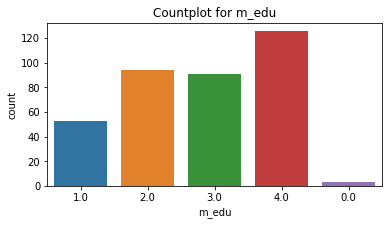

count     367.0
unique      5.0
top         4.0
freq      126.0
Name: m_edu, dtype: float64

Количество уникальных значений: 5
Количество пустых значений: 3


In [24]:
fc.get_countplot('m_edu', math_data)
fc.print_summary('m_edu', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Количество пустых значений минимальное.

## Колонка "f_edu"

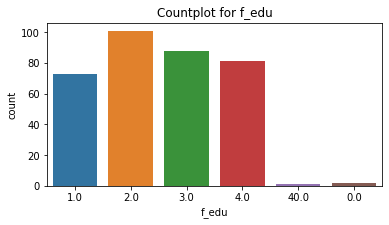

count     346.0
unique      6.0
top         2.0
freq      101.0
Name: f_edu, dtype: float64

Количество уникальных значений: 6
Количество пустых значений: 24


In [25]:
fc.get_countplot('f_edu', math_data)
fc.print_summary('f_edu', math_data)

In [95]:
math_data.f_edu.value_counts()

2.0    101
3.0     88
4.0     82
1.0     73
0.0      2
Name: f_edu, dtype: int64

Количество пустых значений довольно велико. Очевидно, что в колонке "f_edu" значение переменной '40' - это опечатка, исправим на '4'.

In [26]:
math_data.f_edu = math_data.f_edu.apply(
    lambda x: x if x != 40.0 else 4.0).astype(object)

## Колонка "m_job"

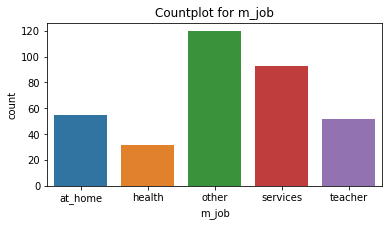

count       352
unique        5
top       other
freq        120
Name: m_job, dtype: object

Количество уникальных значений: 5
Количество пустых значений: 18


In [27]:
fc.get_countplot('m_job', math_data)
fc.print_summary('m_job', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

## Колонка "f_job"

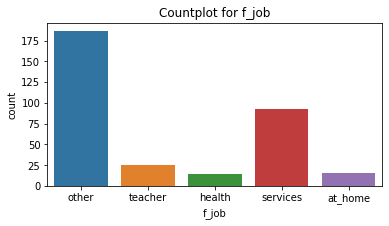

count       335
unique        5
top       other
freq        187
Name: f_job, dtype: object

Количество уникальных значений: 5
Количество пустых значений: 35


In [28]:
fc.get_countplot('f_job', math_data)
fc.print_summary('f_job', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Количество пустых значений довольно велико.

## Колонка "reason"

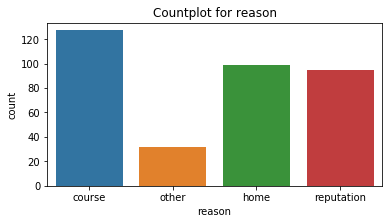

count        353
unique         4
top       course
freq         127
Name: reason, dtype: object

Количество уникальных значений: 4
Количество пустых значений: 17


In [29]:
fc.get_countplot('reason', math_data)
fc.print_summary('reason', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

## Колонка "guardian"

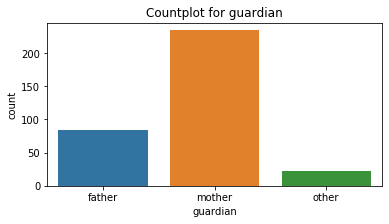

count        340
unique         3
top       mother
freq         234
Name: guardian, dtype: object

Количество уникальных значений: 3
Количество пустых значений: 30


In [30]:
fc.get_countplot('guardian', math_data)
fc.print_summary('guardian', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Количество пустых значений довольно велико.

## Колонка "travel_time"

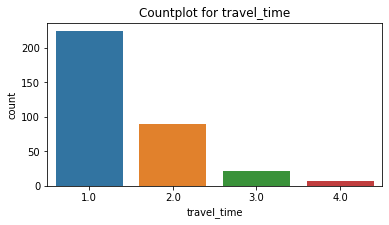

count     342.0
unique      4.0
top         1.0
freq      225.0
Name: travel_time, dtype: float64

Количество уникальных значений: 4
Количество пустых значений: 28


In [31]:
fc.get_countplot('travel_time', math_data)
fc.print_summary('travel_time', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Количество пустых значений довольно велико.

## Колонка "study_time"

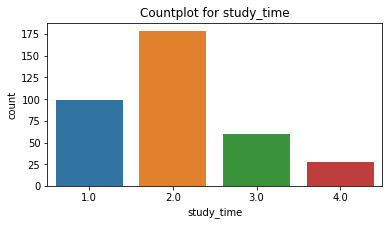

count     365.0
unique      4.0
top         2.0
freq      179.0
Name: study_time, dtype: float64

Количество уникальных значений: 4
Количество пустых значений: 5


In [32]:
fc.get_countplot('study_time', math_data)
fc.print_summary('study_time', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Количество пустых значений минимальное.

## Колонка "failures"

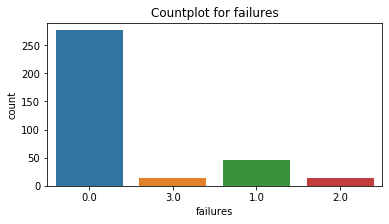

count     348.0
unique      4.0
top         0.0
freq      276.0
Name: failures, dtype: float64

Количество уникальных значений: 4
Количество пустых значений: 22


In [33]:
fc.get_countplot('failures', math_data)
fc.print_summary('failures', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

## Колонка "study_time_granular"

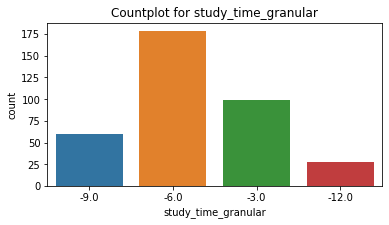

count     365.0
unique      4.0
top        -6.0
freq      179.0
Name: study_time_granular, dtype: float64

Количество уникальных значений: 4
Количество пустых значений: 5


In [34]:
fc.get_countplot('study_time_granular', math_data)
fc.print_summary('study_time_granular', math_data)

У этой колонки описания нет. Но есть описание колонки с похожим названием: "study_time". Проверим как они коррелируют между собой.

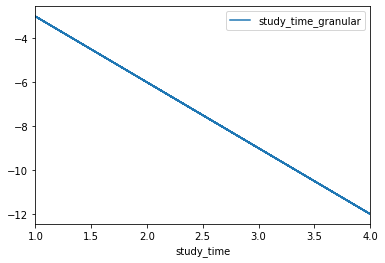

In [35]:
math_data.plot('study_time', 'study_time_granular')

Очевидно, что у этих двух колонок наблюдается 100%-ная корреляция и поскольку информация о шкале оценки для столбца "study_time_granular" отсутствует, лучше удалить именно этот столбец.

In [36]:
math_data.drop(['study_time_granular'], axis=1, inplace=True, )

## Колонка "fam_rel"

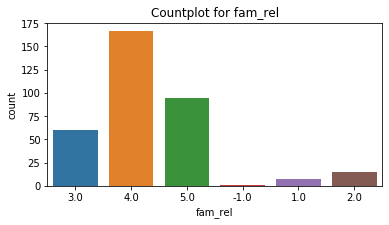

count     344.0
unique      6.0
top         4.0
freq      167.0
Name: fam_rel, dtype: float64

Количество уникальных значений: 6
Количество пустых значений: 26


In [37]:
fc.get_countplot('fam_rel', math_data)
fc.print_summary('fam_rel', math_data)

In [96]:
math_data.fam_rel.value_counts()

4.0    167
5.0     94
3.0     60
2.0     15
1.0      8
Name: fam_rel, dtype: int64

Количество пустых значений довольно велико. Скорее всего в столбце "health" опечатка и вместо '-1', должно быть '1'. Исправим это.

In [38]:
math_data.fam_rel = math_data.fam_rel.apply(
    lambda x: x if x != -1.0 else 1.0).astype(object)

## Колонка "free_time"

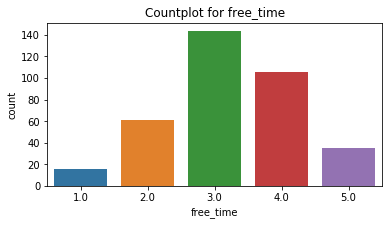

count     362.0
unique      5.0
top         3.0
freq      144.0
Name: free_time, dtype: float64

Количество уникальных значений: 5
Количество пустых значений: 8


In [39]:
fc.get_countplot('free_time', math_data)
fc.print_summary('free_time', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

## Колонка "go_out"

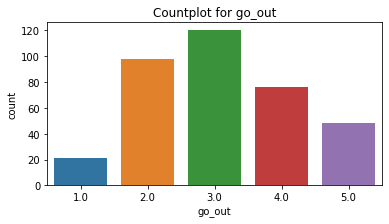

count     363.0
unique      5.0
top         3.0
freq      120.0
Name: go_out, dtype: float64

Количество уникальных значений: 5
Количество пустых значений: 7


In [40]:
fc.get_countplot('go_out', math_data)
fc.print_summary('go_out', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

## Колонка "health"

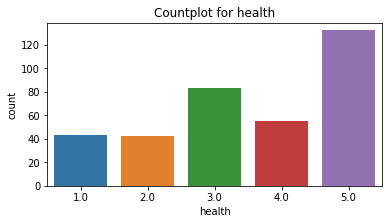

count     355.0
unique      5.0
top         5.0
freq      132.0
Name: health, dtype: float64

Количество уникальных значений: 5
Количество пустых значений: 15


In [41]:
fc.get_countplot('health', math_data)
fc.print_summary('health', math_data)

Количество уникальных значений совпадает с описанием, аномалий нет. Есть пустые значения.

Поскольку была удалена колонка study_time_granular, обновим список небинарных колонок.

In [42]:
categorical_columns = [
    c for c in math_data.columns if math_data[c].dtype.name == 'object']
nonbinary_columns = [
    c for c in categorical_columns if math_describe[c]['unique'] > 2]

## Распределение баллов за экзамен по математике в зависимости от значения небинарных переменных.

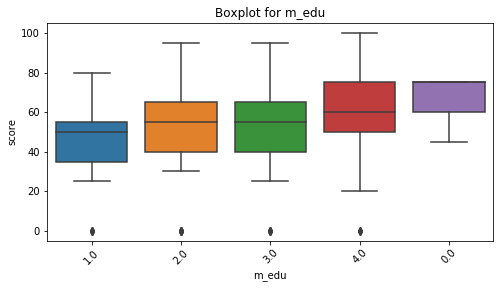

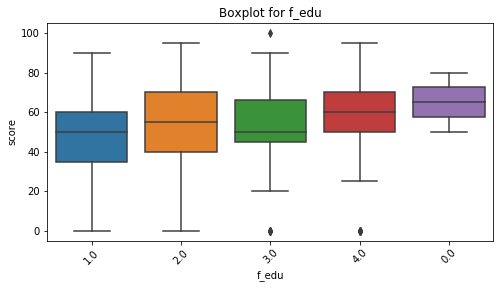

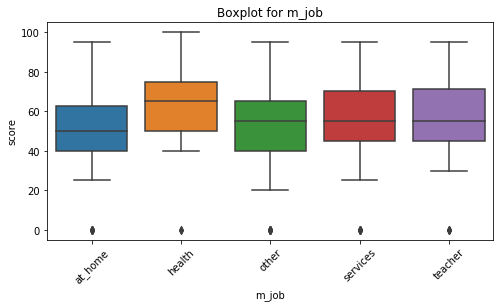

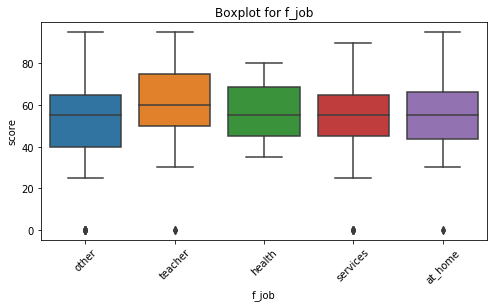

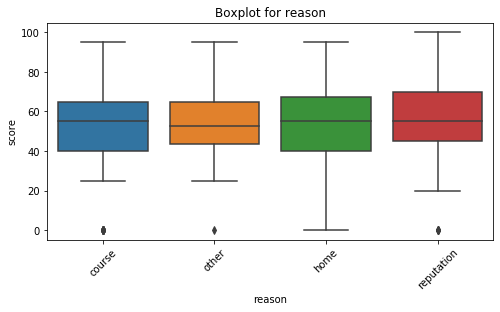

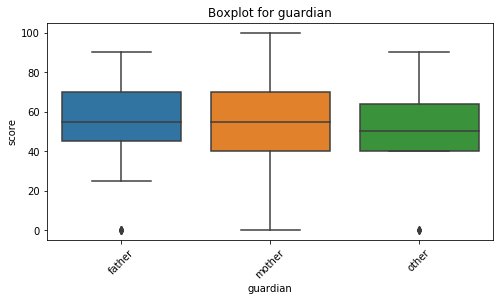

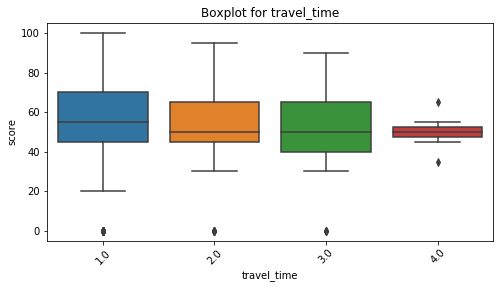

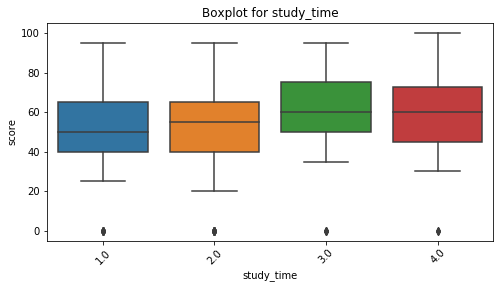

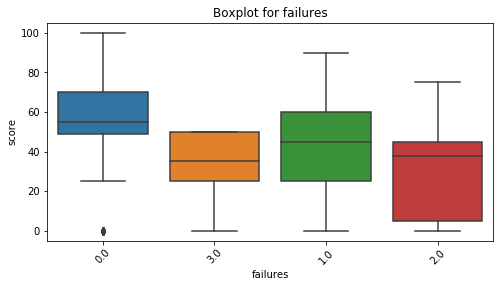

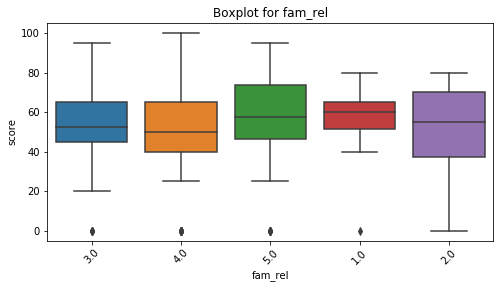

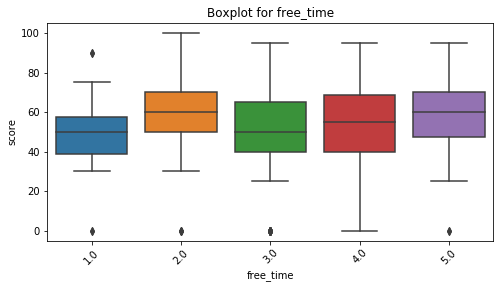

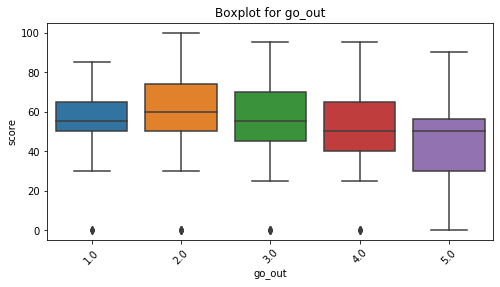

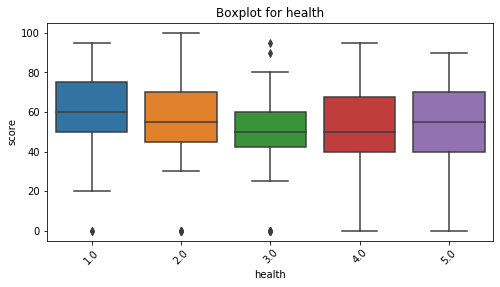

In [43]:
for column in nonbinary_columns:
    fc.get_boxplot(column, target_column='score', data=math_data)

По графикам похоже, что на баллы, полученные за экзамен по математике, могут повлиять все небинарные параметры, кроме 'reason'. Однако проверим это тестом Стьюдента.

In [44]:
for column in nonbinary_columns:
    fc.get_stat_dif(column, target_column='score', data=math_data, alpha=0.1)

Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки m_job
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки go_out


Судя по результатам теста Стьюдента, на баллы по математике могут влиять всего 4 небинарных категориальных признака из 13.

# Колонки с бинарными номинативными признаками

In [45]:
math_data[binary_columns].describe()

,school,sex,address,fam_size,p_status,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic
count,370,370,356,347,329,361,334,332,356,355,351,338,339
unique,2,2,2,2,2,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,no,yes,no,yes,yes,yes,yes,no
freq,327,195,278,247,296,316,207,187,185,282,335,284,223


In [46]:
math_data[binary_columns].isnull().sum()

school         0
sex            0
address       14
fam_size      23
p_status      41
school_sup     9
fam_sup       36
paid          38
activities    14
nursery       15
higher        19
internet      32
romantic      31
dtype: int64

Среди бинарных признаков есть как колонки без пропущенных значений (school, sex), так и колонки со значительным количеством пропущенных значений (p_status, fam_sup, paid). Посмотрим распределение бинарных признаков относительно целевой переменной "score".

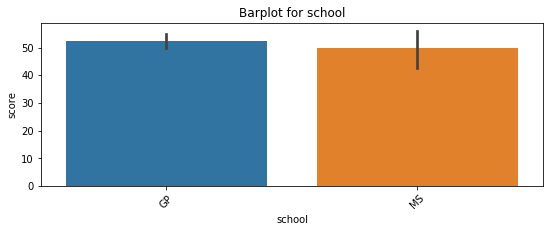

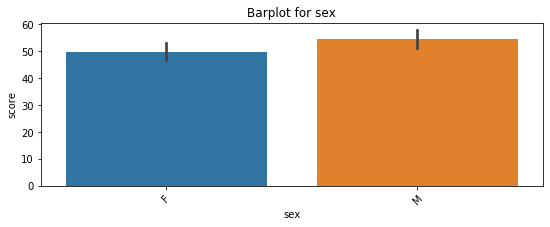

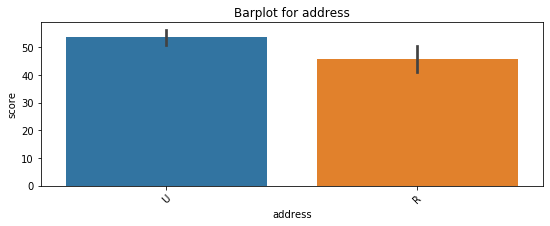

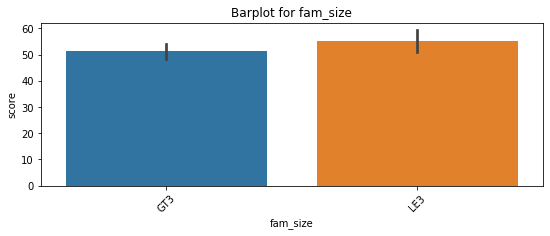

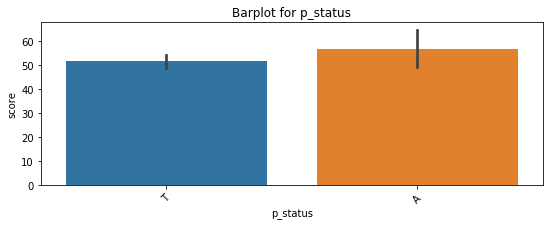

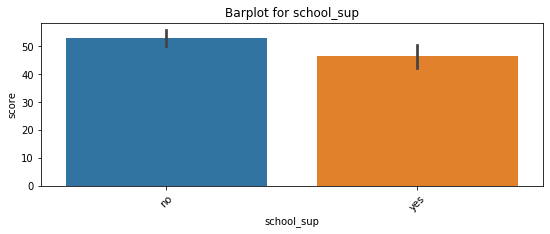

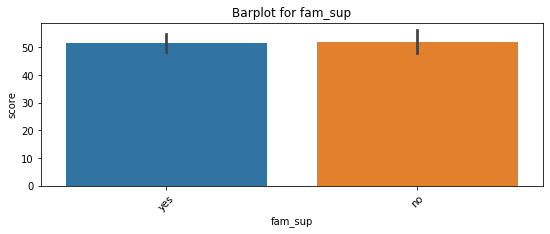

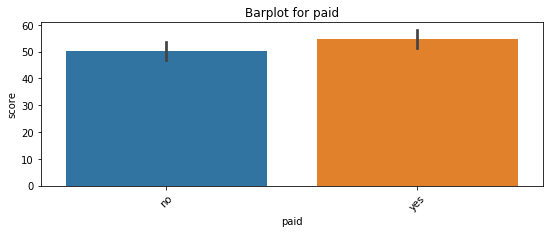

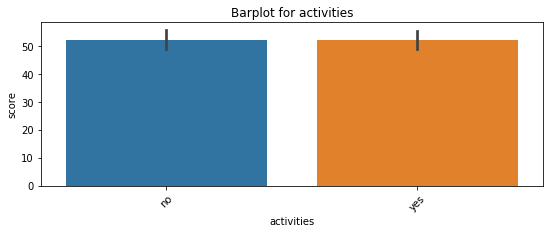

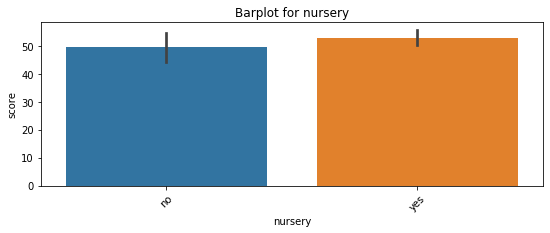

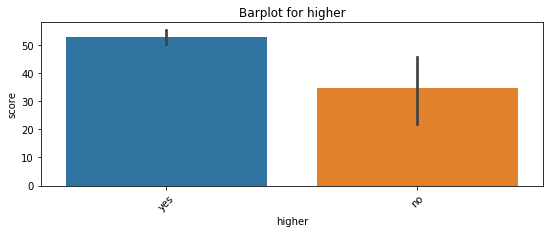

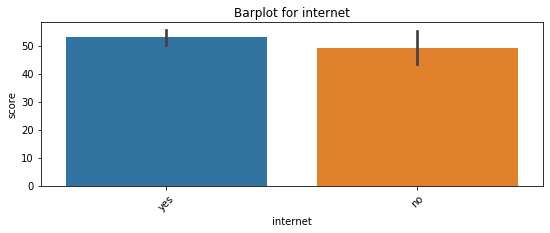

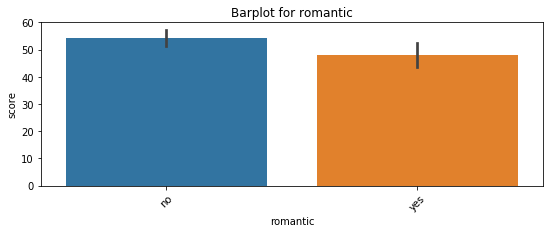

In [47]:
for column in binary_columns:
    fc.get_barplot(column, target_column='score', data=math_data)

По графикам похоже, что на баллы, полученные за экзамен по математике, могут повлиять все бинарные параметры, кроме 'fam_sup' и 'activities'. Однако проверим это тестом Стьюдента.

In [48]:
for column in binary_columns:
    fc.get_stat_dif(column, target_column='score', data=math_data, alpha=0.1)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки school_sup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Судя по результатам теста Стьюдента, на баллы студентов по математике влияют 6 бинарных категориальных признаков из 13.

Оставим в датасете для модели признаки, которые возможно влияют на целевую переменну "score".

# Датасет для модели

Итак, по результатам корреляционного анализа для числовых переменных и теста Стьюдента для номинативных переменных в модель необходимо включить следующие признаки: 'sex', 'age', 'address', 'm_edu', 'm_job', 'failures', 'school_sup', 'paid', 'higher', 'romantic', 'go_out', 'absences', 'score'.
    
    
    

In [49]:
math_data_for_model = math_data.loc[:, ['sex', 'age', 'address', 'm_edu', 'm_job',
                                        'failures', 'school_sup', 'paid', 'higher', 'romantic', 'go_out', 'absences', 'score']]

In [50]:
math_data_for_model.info()
math_data_for_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 1 to 394
Data columns (total 13 columns):
sex           370 non-null object
age           370 non-null int64
address       356 non-null object
m_edu         367 non-null object
m_job         352 non-null object
failures      348 non-null object
school_sup    361 non-null object
paid          332 non-null object
higher        351 non-null object
romantic      339 non-null object
go_out        363 non-null object
absences      370 non-null float64
score         370 non-null float64
dtypes: float64(2), int64(1), object(10)
memory usage: 50.5+ KB


,sex,age,address,m_edu,m_job,failures,school_sup,paid,higher,romantic,go_out,absences,score
1,F,17,U,1,at_home,0,no,no,yes,no,3,4.0,30.0
2,F,15,U,1,at_home,3,yes,NaN,yes,NaN,2,10.0,50.0
3,F,15,U,4,health,0,no,yes,yes,yes,2,2.0,75.0
4,F,16,U,3,other,0,no,yes,yes,no,2,4.0,50.0
5,M,16,U,4,services,0,no,yes,yes,no,2,10.0,75.0


# Выводы

В результате EDA для анализа влияния условий жизни учеников на баллы за госэкзамен по математике были получены следующие выводы:

- В данных достаточно мало пустых значений, часть столбцов вообще не имели пропусков.
- Выбросы найдены только в столбце с количеством пропущенных занятий (absences), и только в двух колонках (f_edu и fam_rel) были допущены явные и незначительные опечатки, что позволяет сделать вывод о том, что данные достаточно чистые.
- Необходимо отдельно рассмотреть группу учеников, получивших 0 баллов за экзамен (фактически не пришедших на него или не сдавших свою работу) и проверить, можно ли это предсказать.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'sex', 'age', 'address', 'm_edu', 'm_job','failures', 'school_sup', 'paid', 'higher', 'romantic', 'go_out', 'absences', 'score'.

# Дополнительно: попытка построения модели

In [51]:
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [52]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [53]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Проверим сколько пропусков содержит каждая колонка, отобранная для модели.

In [55]:
math_data_for_model.isnull().sum()

sex            0
age            0
address       14
m_edu          3
m_job         18
failures      22
school_sup     9
paid          38
higher        19
romantic      31
go_out         7
absences       0
score          0
dtype: int64

У числовых колонок пропусков нет. Пропущенные категориальные значения заполним наиболее часто встречающимся значением.

In [56]:
nan_columns = list(
    math_data_for_model.columns[math_data_for_model.isnull().sum() > 0])
for column in nan_columns:
    fc.fill_data(column, data=math_data_for_model)
    fc.change_to_object(column, data=math_data_for_model)

In [57]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies.
# Тут я возьму в обработку все object признаки.
object_columns = [
    s for s in math_data_for_model.columns if math_data_for_model[s].dtypes == 'object']

math_data_for_model = pd.get_dummies(
    math_data_for_model, columns=object_columns, dummy_na=True)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(math_data_for_model.drop(['score'], axis=1),
                                                    math_data_for_model.score,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [59]:
math_data_for_model.shape, X_train.shape, X_test.shape

((370, 44), (296, 43), (74, 43))

In [60]:
model = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [61]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [62]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 16.14864864864865


### Попытка построения модели (вариант 2)

Если удалить из датасета записи, где за экзамен получено 0 баллов, можно улучшить предсказание.

In [63]:
math_data_2 = math_data.loc[math_data.score > 0]

Проведем тест Стьюдента для номинативных переменных. Для этого отберем номинативные признаки.

In [65]:
categorical_columns = [
    c for c in math_data_2.columns if math_data_2[c].dtype.name == 'object']

In [66]:
for column in categorical_columns:
    fc.get_stat_dif(column, target_column='score', data=math_data_2, alpha=0.1)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки m_edu
Найдены статистически значимые различия для колонки f_edu
Найдены статистически значимые различия для колонки m_job
Найдены статистически значимые различия для колонки study_time
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки school_sup
Найдены статистически значимые различия для колонки go_out


Оставим в новом датасете для модели признаки, которые возможно влияют на целевую переменну "score".

In [67]:
math_data_for_model_2 = math_data_2.loc[:, ['sex', 'age', 'address', 'm_edu', 'f_edu', 'm_job', 'study_time',
                                            'failures', 'school_sup', 'go_out', 'absences', 'score']]

In [68]:
math_data_for_model_2.isnull().sum()

sex            0
age            0
address       13
m_edu          2
f_edu         21
m_job         16
study_time     5
failures      20
school_sup     9
go_out         6
absences       0
score          0
dtype: int64

У числовых колонок пропусков нет. Пропущенные категориальные значения заполним наиболее часто встречающимся значением.

In [69]:
nan_columns = list(
    math_data_for_model_2.columns[math_data_for_model_2.isnull().sum() > 0])
for column in nan_columns:
    fc.fill_data(column, data=math_data_for_model_2)
    fc.change_to_object(column, data=math_data_for_model_2)

In [70]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# Тут я возьму в обработку все object признаки.
object_columns = [
    s for s in math_data_for_model_2.columns if math_data_for_model_2[s].dtypes == 'object']

math_data_for_model_2 = pd.get_dummies(
    math_data_for_model_2, columns=object_columns, dummy_na=True)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(math_data_for_model_2.drop(['score'], axis=1),
                                                    math_data_for_model_2.score,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [72]:
math_data_for_model_2.shape, X_train.shape, X_test.shape

((334, 46), (267, 45), (67, 45))

In [73]:
model = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [74]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [75]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 13.468656716417911


На следующем этапе надо обработать часть записей, где ученики не пришли на экзамен и попробовать предсказать это на основе остальных признаков в датасете.

Добавим в датасет колонку come_to_exam, где 1 присвоим тем, кто пришел на экзамен (получил больше 0 баллов) и соответственно 0 тем, кто не пришел (получил 0 баллов).

In [76]:
math_data['come_to_exam'] = math_data.apply(
    lambda x: 1 if x['score'] > 0 else 0, axis=1)
math_data.head()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score,come_to_exam
1,GP,F,17,U,GT3,NaN,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,3,4.0,30.0,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,NaN,no,yes,yes,yes,NaN,4,3,2,3,10.0,50.0,1
3,GP,F,15,U,GT3,T,4,2,health,NaN,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,5,2.0,75.0,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,5,4.0,50.0,1
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,5,10.0,75.0,1


In [77]:
math_data.come_to_exam.value_counts()

1    334
0     36
Name: come_to_exam, dtype: int64

In [78]:
# Удалим столбец score
math_data.drop(['score'], axis=1, inplace=True, )

,age,absences,come_to_exam
age,1.000000,0.155577,-0.099898
absences,0.155577,1.000000,0.286650
come_to_exam,-0.099898,0.286650,1.000000


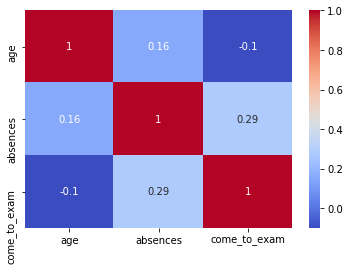

In [79]:
# Проверим корреляцию числовых переменных
correlation = math_data.corr()
display(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Переменные не коррелируют между собой, можно оставить для модели.

In [80]:
# Для категориальных переменных выполним тест Стьюдента.
for column in categorical_columns:
    fc.get_stat_dif(column, target_column='come_to_exam',
                    data=math_data, alpha=0.1)

Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки school_sup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [81]:
# Создадим датасет для модели.
math_data_for_model_3 = math_data.loc[:, [
    'age', 'failures', 'school_sup', 'paid', 'higher', 'romantic', 'absences', 'come_to_exam']]

In [82]:
# Заполняем пропущенные категориальные значения.
nan_columns = list(
    math_data_for_model_3.columns[math_data_for_model_3.isnull().sum() > 0])
for column in nan_columns:
    fc.fill_data(column, data=math_data_for_model_3)
    fc.change_to_object(column, data=math_data_for_model_3)

In [83]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# Тут я возьму в обработку все object признаки.
object_columns = [
    s for s in math_data_for_model_3.columns if math_data_for_model_3[s].dtypes == 'object']

math_data_for_model_3 = pd.get_dummies(
    math_data_for_model_3, columns=object_columns, dummy_na=True)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(math_data_for_model_3.drop(['come_to_exam'], axis=1),
                                                    math_data_for_model_3.come_to_exam,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [85]:
math_data_for_model_3.shape, X_train.shape, X_test.shape

((370, 20), (296, 19), (74, 19))

In [86]:
model = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [87]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [88]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.11460090585090585


Но мне кажется, что так делать было нельзя, т.к. 'come_to_exam' не числовая, а категориальная переменная, где "yes" и "no" зашиврованы как 1 и 0. 